In [1]:
from airpy.agd import * # age+gender predict data

check, pre_age = pre_age_set_data(train_users_2, test_users)
pre_gen_mission_test, pre_gen_train_test, pre_gen_mission, pre_gen_train, \
            pre_gen_mission_test_drop, pre_gen_train_test_drop = pre_gen_predict_data(pre_age)

model_gen_lgb = predict_gen_LightGBM(pre_gen_train_test_drop, pre_gen_train_test, pre_gen_train_test_drop)
model_gen_lgb.to_csv("model_gen_lgb.csv", index=False)
pre_age_mission_test, pre_age_train_test, pre_age_mission, pre_age_train, \
            pre_age_mission_test_drop, pre_age_train_test_drop = pre_age_predict_data(pre_age)

cats = pre_age_predict_data_cat(pre_age_train)
model_age_lgb = predict_age_LightGBM(pre_age_train_test_drop, cats, pre_age_mission_test_drop)
model_age_lgb.to_csv("model_age_lgb.csv", index=False)

             precision    recall  f1-score   support

     FEMALE       0.58      0.72      0.65     77524
       MALE       0.57      0.42      0.48     68209

avg / total       0.58      0.58      0.57    145733

             precision    recall  f1-score   support

         노년       0.67      0.00      0.01      9993
       미성년자       0.90      0.65      0.75        68
         장년       0.48      0.38      0.43     55518
         중년       0.50      0.79      0.61     70900
         청년       0.55      0.04      0.08     22202

avg / total       0.51      0.49      0.43    158681



In [ ]:
import gc

gc.collect()

In [2]:
from airpy.merge import * # sessions merged data

merged_sessions = make_merged_sessions()
merged_sessions = remove_word()
merged_sessions = sessions_detail_add()

In [ ]:
gc.collect()

In [3]:
from airpy.data import * # classification data

check, pre_age = pre_age_set_data(train_users_2, test_users)

pre_age_mission_test, pre_age_train_test, pre_age_mission, pre_age_train, \
            pre_age_mission_test_drop, pre_age_train_test_drop = pre_age_predict_data(pre_age)

cats = pre_age_predict_data_cat(pre_age_train)
last_gen_add = add_gender(pre_age)
add_hol = holiday(train_users_2, test_users)
last_train_data, last_test_data, y_label, le = predict_age_add(pre_age_mission_test, pre_age_train_test, last_gen_add, add_hol)
last_train_data_add, last_test_data_add = last_data_setting(last_train_data, last_test_data)

In [ ]:
gc.collect()

In [7]:
def pre_setting():
    last_train_data_add = pd.read_csv("last_train_data_add.csv")
    last_test_data_add = pd.read_csv("last_test_data_add.csv")
    
    X = last_train_data_add
    y = last_test_data_add
    
#     clf1 = linear_model.LogisticRegression(n_jobs=-1)
#     clf2 = RandomForestClassifier(n_jobs=-1)
#     clf3 = ExtraTreesClassifier(n_jobs=-1)
#     clf4 = xgb.XGBClassifier(nthread=3, n_jobs=-1)
    clf5 = lgb.LGBMClassifier(nthread=3, n_jobs=-1, reg_alpha=1)
#     eclf2 = VotingClassifier(estimators=[('log', clf1), ('rf', clf2), ('ex', clf3), ('xgb', clf4), ('lgb', clf5)], voting='soft', weights=[1,1,1,1,1])
    
    return X, y, clf5

In [8]:
X, y, clf5  = pre_setting()

In [13]:
X.shape, y.shape

((213461, 1051), (62096, 1051))

In [ ]:
gc.collect()

In [11]:
def submit_kaggle(df_train, df_test, model, user_id, target):
    
    le = LabelEncoder()

    y_train = le.fit_transform(df_train[target])
    X_train = df_train.drop([target, user_id], axis = 1)
    
    X_test_id = df_test[user_id]
    X_test = df_test.drop([target, user_id], axis = 1)
    

    print("model fitting 시작")
    
    model = model.fit(X_train, y_train)
    
    predic_proba = model.predict_proba(X_test)
    
   
    print("model fitting 종료")

    df_submit = pd.DataFrame(columns=["id", "country"])
    ids = []
    cts = []
    for i in range(len(X_test_id)):
        idx = X_test_id.iloc[i]
        ids += [idx] * 5
        cts += le.inverse_transform(np.argsort(predic_proba[i])[::-1])[:5].tolist()
    df_submit["id"] = ids
    df_submit["country"] = cts
    df_submit.to_csv('submit_lgb.csv', index = False)
    print("csv file 생성")
    !kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f 'submit_lgb.csv' -m "Message"

In [12]:
submit_kaggle(X, y, clf5, "id", "country_destination")

model fitting 시작
model fitting 종료
csv file 생성
Successfully submitted to Airbnb New User Bookings

In [17]:
import matplotlib.pyplot as plt

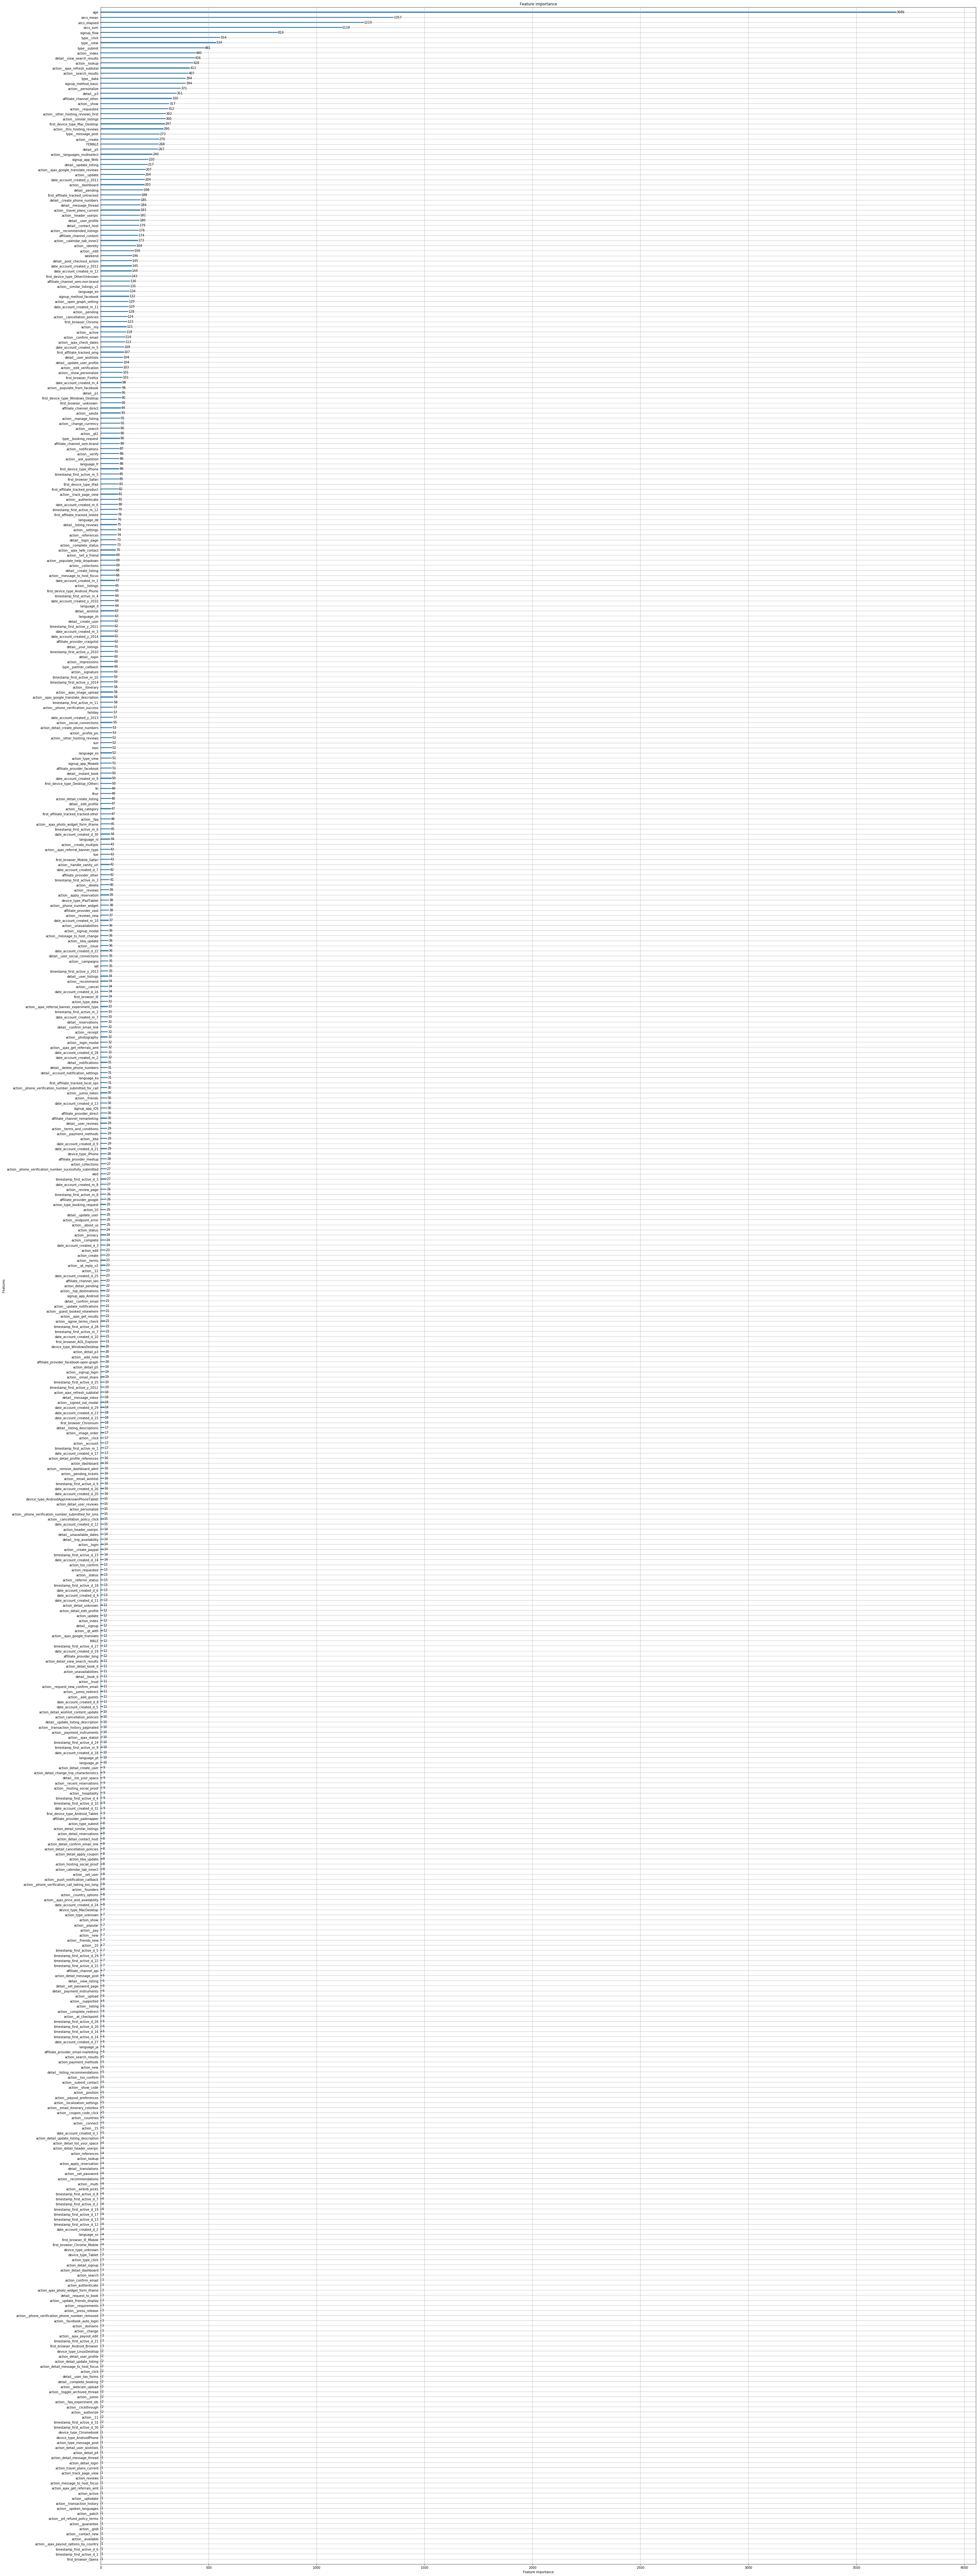

In [18]:
lgb.plot_importance(clf5, figsize=(50,150))
plt.show()

In [19]:
np.mean(clf5.feature_importances_)

32.9256434699714

In [20]:
np.median(clf5.feature_importances_)

0.0